# Problem Statement

Thera Bank Data-
Campaign for selling personal loans

Build a model that will help bank to identify the potential customers who have higher probability of purchasing the loan with increase in the success ratio while at the same time reduce the cost of the campaign.

In [22]:
#Import all the necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

### 1. Read the column description and ensure you understand each attribute well

In [23]:
Bank_data = pd.read_csv("Bank_PLM.csv")
Bank_data.sample(10)

,"""ID""",Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
2812,2813,53,28,183,96008,3,8.2,3,467,1,0,1,1,1
287,288,37,12,62,92110,3,0.7,2,0,0,0,0,0,1
2742,2743,39,14,89,95762,2,0.4,1,0,0,0,0,1,0
2557,2558,36,11,23,94553,4,0.2,3,0,0,0,0,1,0
3003,3004,52,28,44,90747,3,1.9,2,0,0,0,0,0,1
2023,2024,55,29,55,94720,1,0.2,1,151,0,0,0,1,0
2441,2442,64,38,38,94305,2,0.3,1,186,0,0,0,1,1
349,350,26,2,60,93407,2,3.0,1,132,1,0,0,0,0
125,126,60,35,80,91301,3,0.5,1,0,0,0,0,1,0
3025,3026,58,32,128,94609,2,2.7,1,344,0,0,0,0,0


In [24]:
print (Bank_data.isna().sum())
print ("=========================================")
Bank_data.info()

"ID"                  0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
"ID"                  5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null in

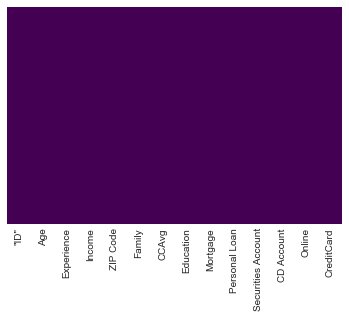

In [25]:
sns.heatmap(Bank_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [26]:
Bank_data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
"""ID""",5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [27]:
# Experience attribute have -ve min value, which is not valid.
# Get the count of -ve value records in Experience attribute.
Bank_data[Bank_data.Experience < 0].Experience.count()

52

## Observations:
### So from the above randon sample 10 rows displayed, We can see that the dataset has the following columns (with their type):

#### Age: multi-valued discrete
#### Experience: multi-valued discrete
#### Income: multi-valued discrete
#### Zipcode: multi-valued discrete
#### Family: multi-valued discrete
#### CCAvg: continuous
#### Education: multi-valued discrete
#### Mortgage: multi-valued discrete
#### Personal Loan: Binary
#### Securities Account: Binary
#### CD Account: Binary
#### Online: Binary
#### CreditCard: Binary

#### There is no missing or null values.
#### Experience attribute have -ve values (52 rows) which is not valid. Data error needs to be corrected.

## Negative Experience cleaning
### Treating the -ve experience with median of experience having same age and education.

In [28]:
CorrectExp= Bank_data.loc[Bank_data['Experience'] >0]
WrongExp = Bank_data.Experience < 0
IDlist = Bank_data.loc[WrongExp]['"ID"'].tolist()

In [29]:
# Treating the -ve experience with median of experience having same age and education. Treating with 0, if no records of same age and education found.
for id in IDlist:
    age = Bank_data.loc[np.where(Bank_data['"ID"']==id)]["Age"].tolist()[0]
    education = Bank_data.loc[np.where(Bank_data['"ID"']==id)]["Education"].tolist()[0]
    df_filtered = CorrectExp[(CorrectExp.Age == age) & (CorrectExp.Education == education)]
    if df_filtered.Experience.count() > 0:
        exp = df_filtered['Experience'].median()
    else:
        exp = 0
    Bank_data.loc[Bank_data.loc[np.where(Bank_data['"ID"']==id)].index, 'Experience'] = exp

In [30]:
Bank_data.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
"""ID""",5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.125800,11.430053,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [31]:
# Dropping the ID column as it is not required for our analysis.
Bank_data.drop(['"ID"'], axis=1, inplace=True)

### 2. Study the data distribution in each attribute, share your findings. (5 points)

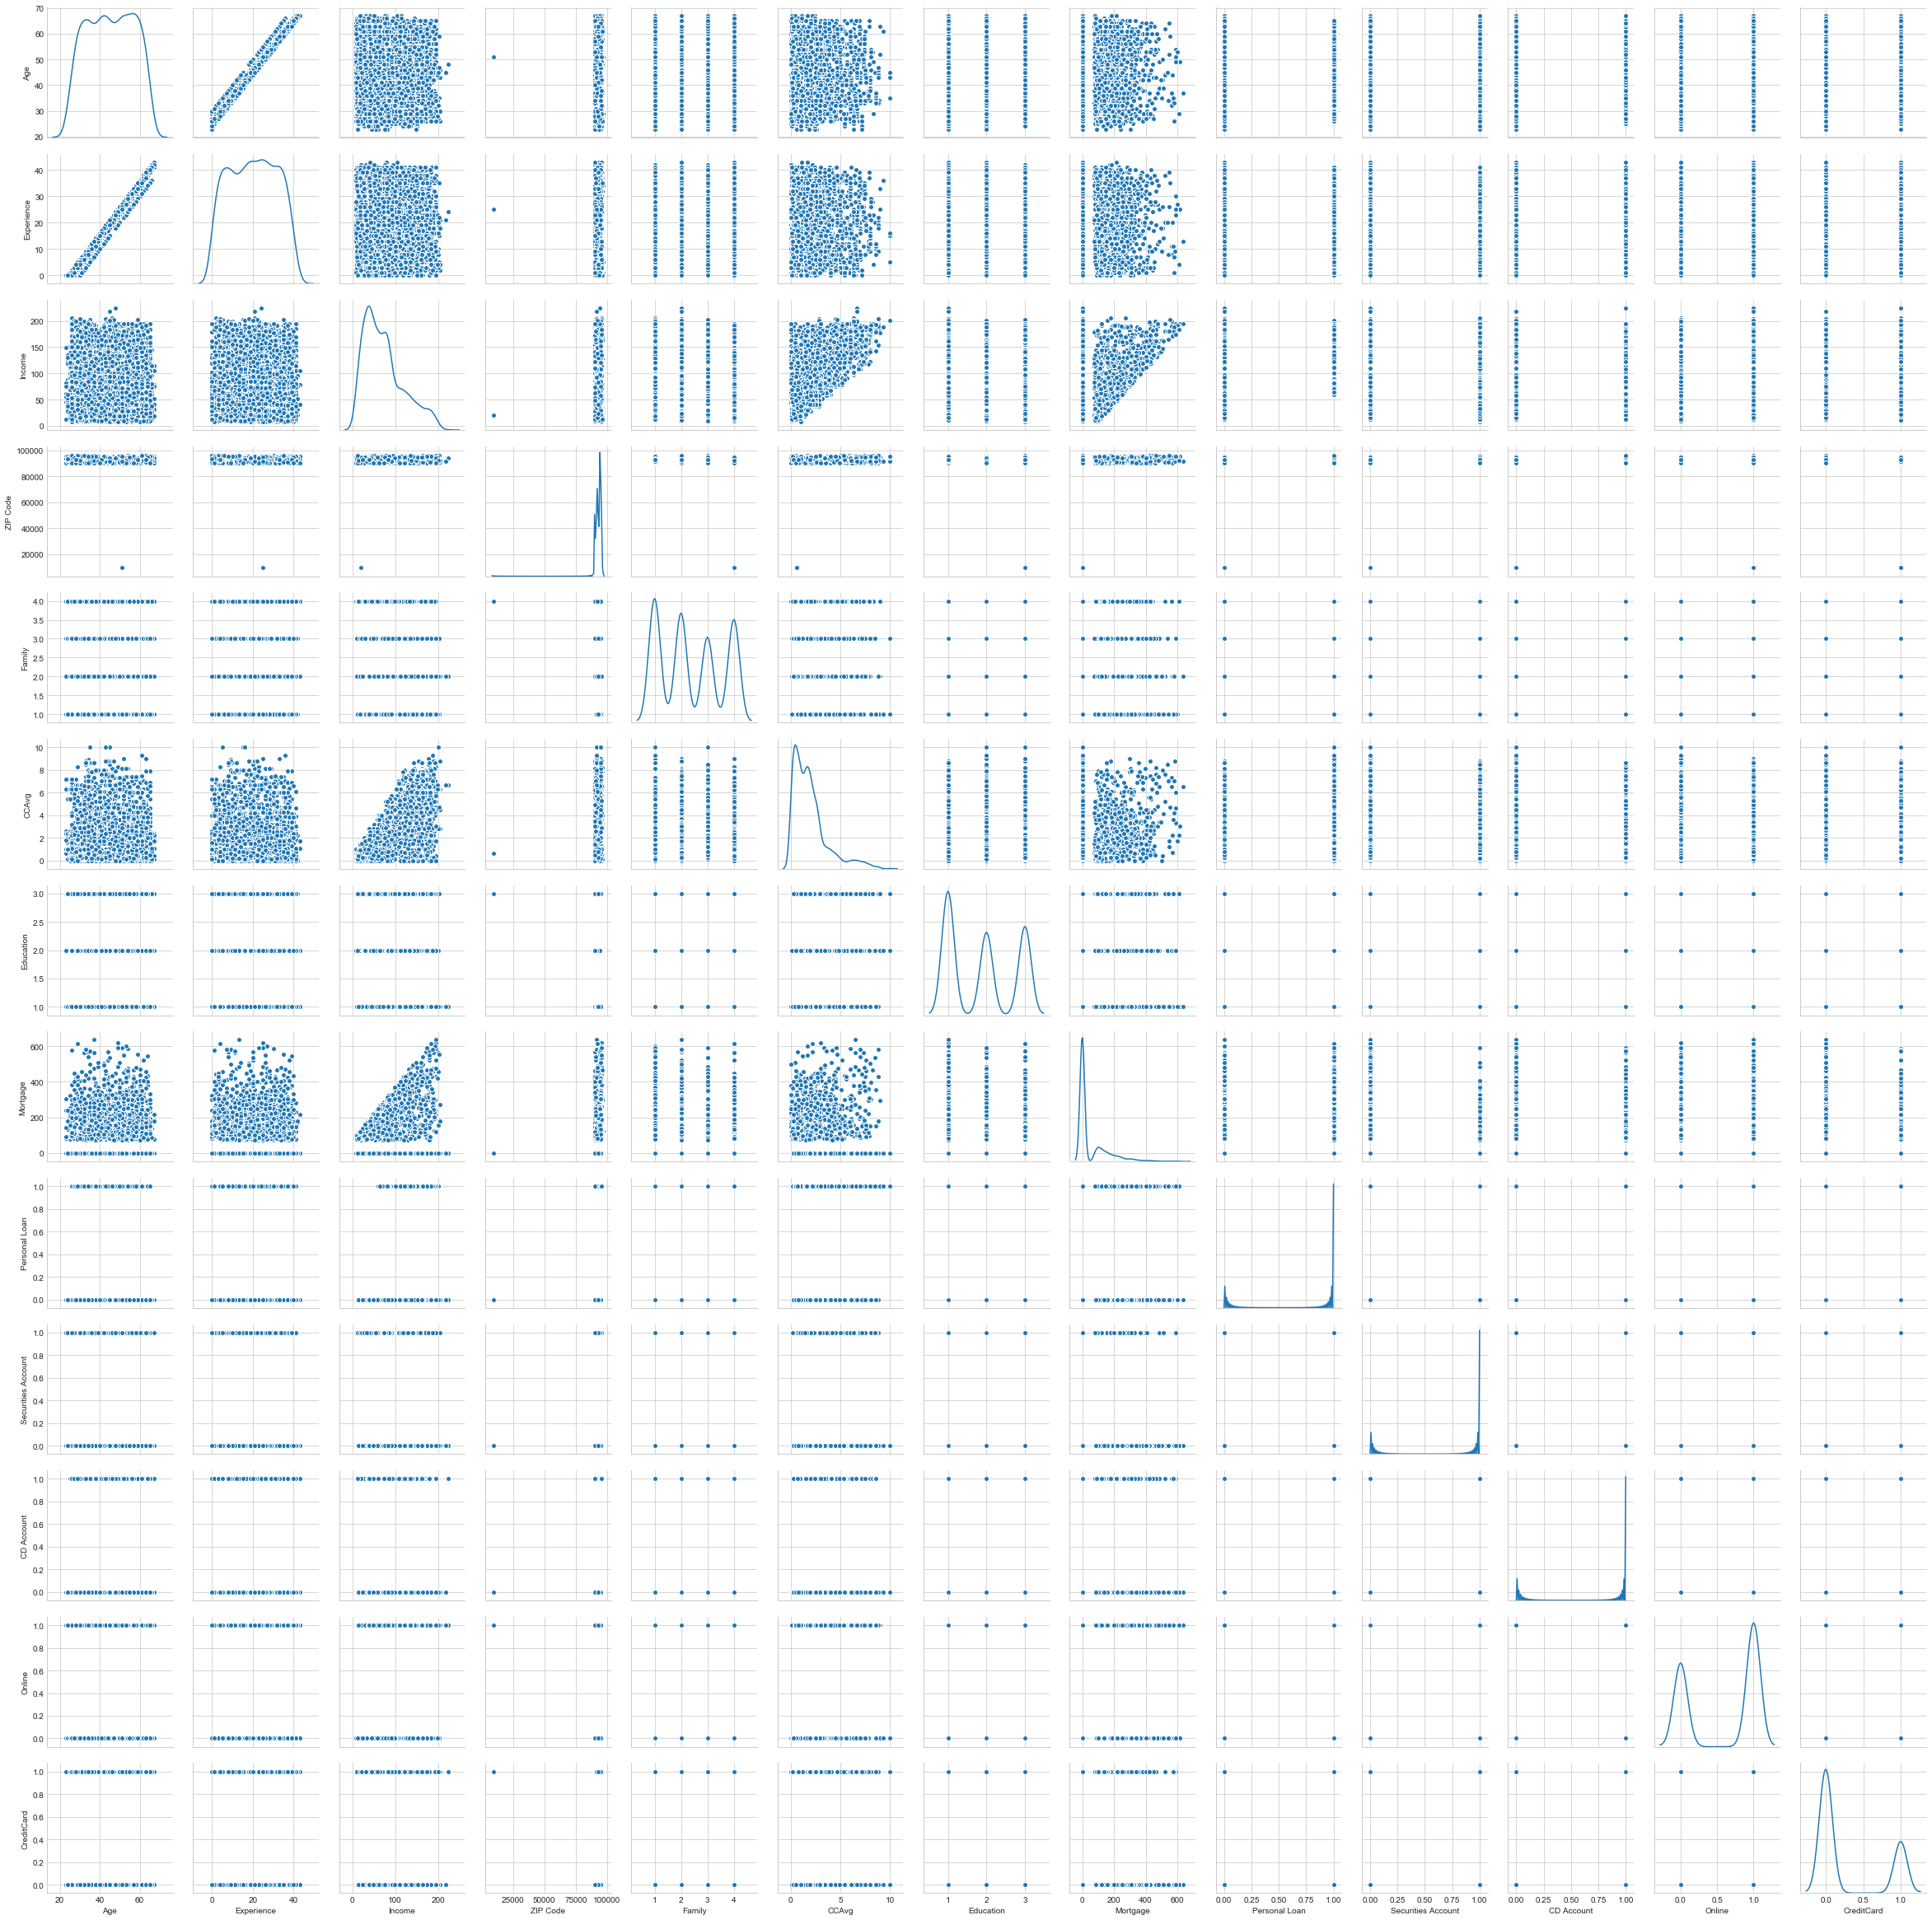

In [32]:
sns.pairplot(Bank_data, diag_kind='kde')

## Observations:
### There is atleast 2 or 3 good clusters.
### Most of the attributes have multimodal distribution.
### Income, CCAVG feature has right skewed/tailed distribution.
### None of the features have linear relationship except experience and Age.

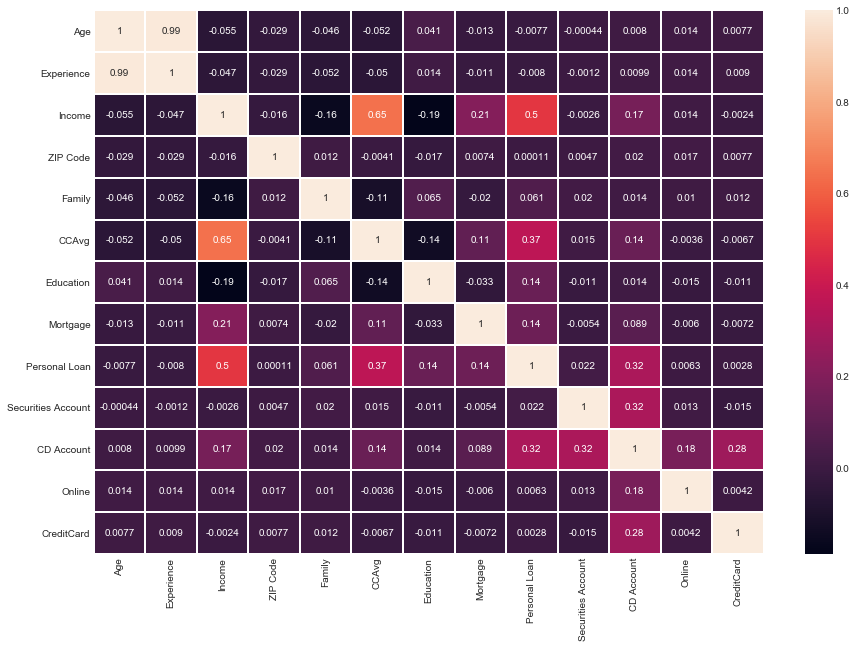

In [33]:
plt.subplots(figsize=(15,10))
sns.heatmap(Bank_data.corr(), annot=True, linewidths=1)

In [34]:
CorrMat = Bank_data.corr()
indices = np.where((CorrMat < 0.1) & (CorrMat > -0.1))
indices = [(CorrMat.index[x], CorrMat.columns[y]) for x, y in zip(*indices) if x != y and x < y]
print ("There is no significant correlation between the following attributes: ")
print ("------------------------------------------------------------------------")
print(indices)
print("====================================================================")
indices = np.where((CorrMat < 0.1) & (CorrMat > -0.1))
indices = [(CorrMat.index[x]) for x, y in zip(*indices) if x != y and x < y and y == 8]
print ("There is no significant correlation between Personal Loan and the following attributes: ", indices)

There is no significant correlation between the following attributes: 
------------------------------------------------------------------------
[('Age', 'Income'), ('Age', 'ZIP Code'), ('Age', 'Family'), ('Age', 'CCAvg'), ('Age', 'Education'), ('Age', 'Mortgage'), ('Age', 'Personal Loan'), ('Age', 'Securities Account'), ('Age', 'CD Account'), ('Age', 'Online'), ('Age', 'CreditCard'), ('Experience', 'Income'), ('Experience', 'ZIP Code'), ('Experience', 'Family'), ('Experience', 'CCAvg'), ('Experience', 'Education'), ('Experience', 'Mortgage'), ('Experience', 'Personal Loan'), ('Experience', 'Securities Account'), ('Experience', 'CD Account'), ('Experience', 'Online'), ('Experience', 'CreditCard'), ('Income', 'ZIP Code'), ('Income', 'Securities Account'), ('Income', 'Online'), ('Income', 'CreditCard'), ('ZIP Code', 'Family'), ('ZIP Code', 'CCAvg'), ('ZIP Code', 'Education'), ('ZIP Code', 'Mortgage'), ('ZIP Code', 'Personal Loan'), ('ZIP Code', 'Securities Account'), ('ZIP Code', 'CD Acco

In [35]:
indices = np.where(CorrMat > 0.1)
indices = [(CorrMat.index[x], CorrMat.columns[y]) for x, y in zip(*indices) if x != y and x < y]
print ("There is significant positive correlation between the following attributes: ")
print ("------------------------------------------------------------------------")
print(indices)
print("====================================================================")
indices = np.where(CorrMat > 0.1)
indices = [(CorrMat.index[x]) for x, y in zip(*indices) if x != y and x < y and y == 8]
print ("There is significant positive correlation between Personal Loan and the following attributes: ", indices)

There is significant positive correlation between the following attributes: 
------------------------------------------------------------------------
[('Age', 'Experience'), ('Income', 'CCAvg'), ('Income', 'Mortgage'), ('Income', 'Personal Loan'), ('Income', 'CD Account'), ('CCAvg', 'Mortgage'), ('CCAvg', 'Personal Loan'), ('CCAvg', 'CD Account'), ('Education', 'Personal Loan'), ('Mortgage', 'Personal Loan'), ('Personal Loan', 'CD Account'), ('Securities Account', 'CD Account'), ('CD Account', 'Online'), ('CD Account', 'CreditCard')]
There is significant positive correlation between Personal Loan and the following attributes:  ['Income', 'CCAvg', 'Education', 'Mortgage']


In [36]:
indices = np.where(CorrMat < -0.1)
indices = [(CorrMat.index[x], CorrMat.columns[y]) for x, y in zip(*indices) if x != y and x < y]
print ("There is significant negative correlation between the following attributes: ")
print ("------------------------------------------------------------------------")
print(indices)
print("====================================================================")
indices = np.where(CorrMat < -0.1)
indices = [(CorrMat.index[x]) for x, y in zip(*indices) if x != y and x < y and y == 8]

if len(indices) == 0:
    print ("Personal Loan do not have negative correlation with any attributes.")
else:
    print ("There is significant negative correlation between Personal Loan and the following attributes: ", indices)


There is significant negative correlation between the following attributes: 
------------------------------------------------------------------------
[('Income', 'Family'), ('Income', 'Education'), ('Family', 'CCAvg'), ('CCAvg', 'Education')]
Personal Loan do not have negative correlation with any attributes.


## Observations:
### Have listed the correlation between attributes in the above outputs.
### Personal Lean seams to have some correlation with Income, Education, Mortgage and CCAVG

## 3. Get the target column distribution. Your comments

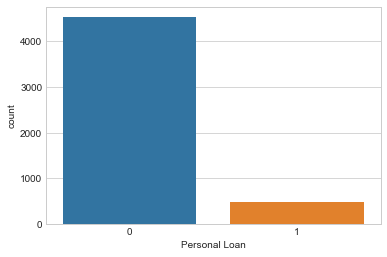

In [37]:
sns.countplot(Bank_data['Personal Loan'])

## Observations:
### We have more datas with Personal Loan as 0 and less datas with Personal Loan as 1. As Personal Loan being the result parmeter, this may lead to accurate prediction for any data with Personal Loan status as 0 rather than the data having Personal Loan status as 1.

C:\Users\Iyyappan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Iyyappan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Iyyappan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Iyyappan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Iyyappan\Anaconda3\lib\site-packages\matplotlib

<Figure size 432x288 with 0 Axes>

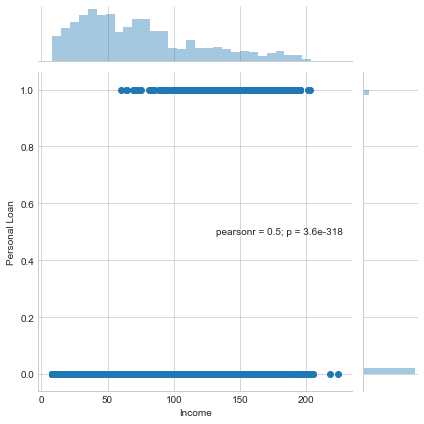

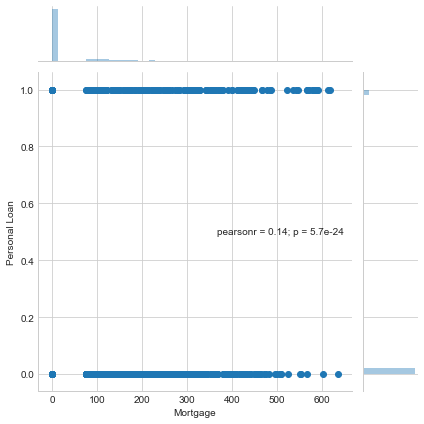

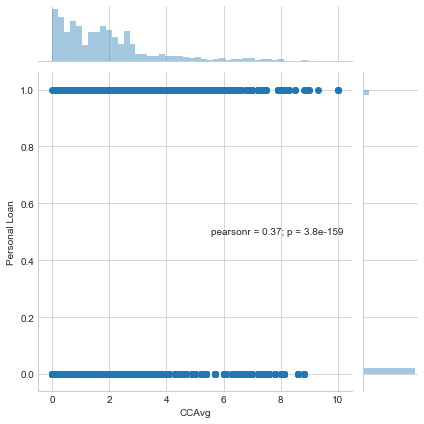

In [38]:
# Lets look at the distribution of Personal Loan attribute with the attributes Income, Education, Mortgage and CCAVG as we have some correlation between them.

disc_cols = ['Income', 'Mortgage', 'CCAvg']
for i, col in enumerate(disc_cols):
    plt.figure(i)
    sns.jointplot(y='Personal Loan', x=col, data=Bank_data)

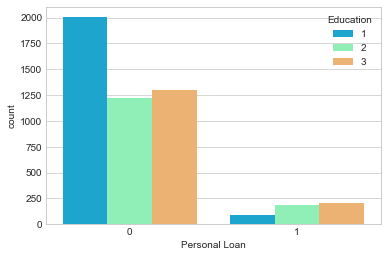

In [39]:
sns.set_style('whitegrid')
sns.countplot(x='Personal Loan',hue='Education',data=Bank_data,palette='rainbow')

<Figure size 432x288 with 0 Axes>

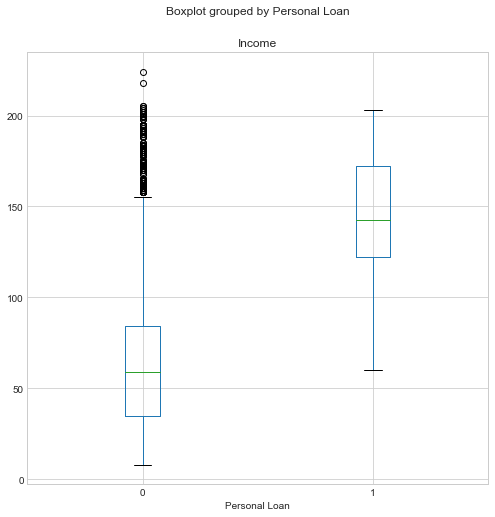

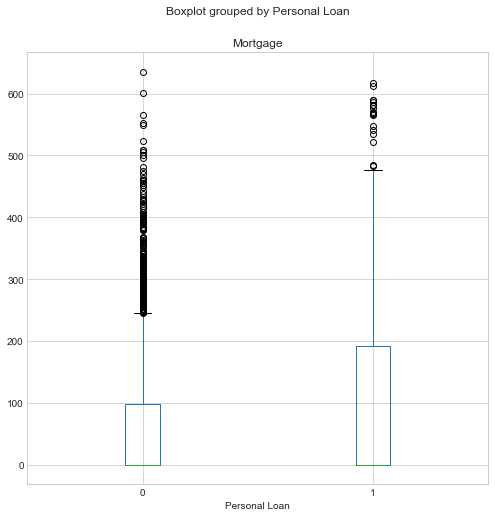

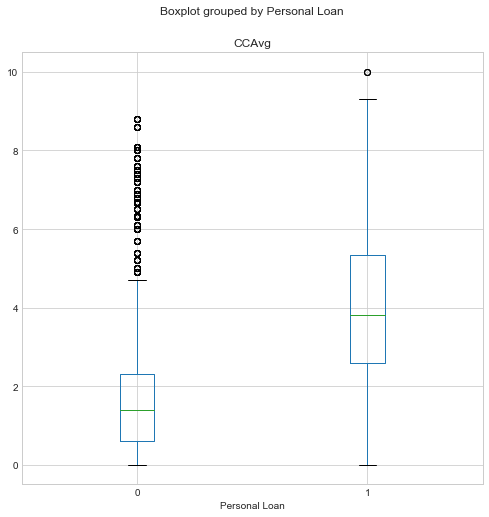

In [40]:
for i, col in enumerate(disc_cols):
    plt.figure(i)
    Bank_data.boxplot(column=col,        # Column to plot
                     by= "Personal Loan",         # Column to split upon
                     figsize= (8,8))

## Observations:
### The persons with lower income have less probability to opt for personal loan.
### The persons with higher education have more probaility to opt for personal loan.
### The persons with higher CCAvg tend to opt for personal loan.
### We have outliers in Income, CCAvg and Mortgage.

## 4. Split the data into training and test set in the ratio of 70:30 respectively

In [41]:
from sklearn.model_selection import train_test_split

X = Bank_data.drop('Personal Loan', axis=1)
Y = Bank_data['Personal Loan']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3, random_state=100)

## 5. Use different classification models (Logistic, K-NN and Naïve Bayes) to predict the likelihood of a liability customer buying personal loans (15 points)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

logmodel = LogisticRegression()
LRmodel = logmodel.fit(X_train,Y_train)
LRpredictions = logmodel.predict(X_test)
print("Logistic Regression Model Accuracy Score: ", accuracy_score(Y_test,LRpredictions))
print ("======================================================================")
print ("Classification Report")
print(classification_report(Y_test, LRpredictions))

Logistic Regression Model Accuracy Score:  0.8993333333333333
Classification Report
             precision    recall  f1-score   support

          0       0.92      0.97      0.95      1342
          1       0.55      0.26      0.35       158

avg / total       0.88      0.90      0.88      1500



In [43]:
from sklearn.neighbors import KNeighborsClassifier
KNNModel = KNeighborsClassifier(weights = 'uniform', metric='euclidean')
KNNModel.fit(X_train, Y_train)
KNNpredictions = KNNModel.predict(X_test)
print("K-NN Model Accuracy Score: ", accuracy_score(Y_test,KNNpredictions))
print ("======================================================================")
print ("Classification Report")
print(classification_report(Y_test, KNNpredictions))

K-NN Model Accuracy Score:  0.892
Classification Report
             precision    recall  f1-score   support

          0       0.91      0.97      0.94      1342
          1       0.47      0.21      0.29       158

avg / total       0.87      0.89      0.87      1500



In [44]:
from sklearn.naive_bayes import GaussianNB
NBmodel = GaussianNB()
NBmodel.fit(X_train, Y_train)
NBpredictions = NBmodel.predict(X_test)
print("Naive Bayes Model Accuracy Score: ", accuracy_score(Y_test,NBpredictions))
print ("======================================================================")
print ("Classification Report")
print(classification_report(Y_test, NBpredictions))

Naive Bayes Model Accuracy Score:  0.8866666666666667
Classification Report
             precision    recall  f1-score   support

          0       0.95      0.92      0.94      1342
          1       0.47      0.61      0.53       158

avg / total       0.90      0.89      0.89      1500



## Observation:
### Based on the accuracy score and Classificatin report, Logistic Model have best prediction rate compared to KNN and Naive.
### Lets look into the confusion matrix and decide on the model.

## 6. Print the confusion matrix for all the above models (5 points)

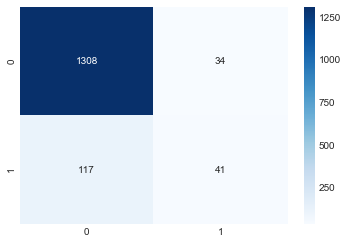

In [45]:
# Logistic Regression Model
sns.heatmap(confusion_matrix(Y_test,LRpredictions), annot=True, cmap='Blues',fmt='g')

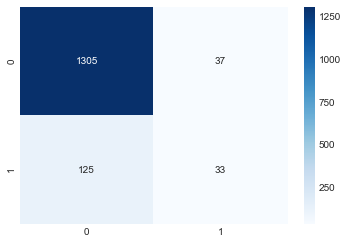

In [46]:
#K-NN Model
sns.heatmap(confusion_matrix(Y_test,KNNpredictions), annot=True, cmap='Blues',fmt='g')

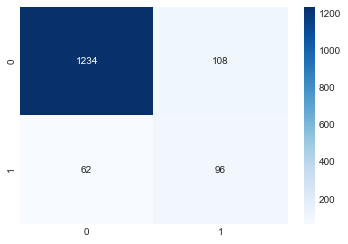

In [47]:
#Naive Bayes Model
sns.heatmap(confusion_matrix(Y_test,NBpredictions), annot=True, cmap='Blues',fmt='g')

## 7. Give your reasoning on which is the best model in this case and why it performs better? (5 points)

## Reasoning the best model:
### Given the problem statement "to identify the potential customers who have higher probability of purchasing the loan", having more False Negative (Model predicted no, but they are actually potential customers who have higher probability of purchasing the loan) is costlier.
### Based on the above confusion matrix by 3 models (Logistic, K-NN and Naive) Naive Bayes model give the less probability of having False Negative results.
### Logistic Regression Model False Negative count: 117 (False Negative Rate: 117/158 = 0.7405)
### K-NN Model False Negative count: 125 (False Negative Rate: 125/158 = 0.7911)
### Naive Bayes Model False Negative count: 62 (False Negative Rate: 62/158 = 0.3924)
### Eventhough the other 2 models (Logistic Regression and K-NN) have more accuracy score than Naive Bayes, I would choose Naive Bayes as a best model for this data/problem considering the risk of having more False Negative probability.